In [1]:
import os
import pandas as pd

#this directory contains the csv with all the models' metrics, and all tables generated in this notebook will go here
results_path = "results/5_final_results/"

In [2]:
#load results
results = pd.read_csv(os.path.join(results_path, "mean.csv"))
#make all the strings 7 digits long by adding zeros in front
results["name"] = results.apply(lambda row: "M" + str(int(row["name"])).zfill(7), axis=1)

#obtain the relative orders of each column, keeping the column name
ranks = results.drop("name", axis=1).rank(ascending=False).add_suffix("_rank")
ranked_results = pd.concat([results, ranks], axis=1)

#find the product of the ranks of each column
metrics_to_eval = ["botwiki-verified_rank", "midterm-18_rank", "gilani-17_rank", "cresci-rtbust_rank", "5-fold_cross-validation_rank", "spearman_r_rank"]
rank_product = ranked_results[metrics_to_eval].product(axis=1)


#drop the ranks of the test metrics since they aren't useful in the tables
ranked_results = ranked_results.drop(labels=ranked_results.columns[7:],axis=1)


#get the rank of the products (used for a lookup later)
ranked_results["rank"] = rank_product.rank(ascending=True)

#once rank is calculated, round all metrics for readability
ranked_results = ranked_results.round(decimals=3)

In [4]:
#get the best n results
n = 5
top_results = ranked_results.sort_values("rank").head(n).set_index("name").transpose()

top_results_file = os.path.join(results_path, "top_results.csv")
top_results.to_csv(top_results_file)

top_models = top_results.columns
top_model = top_models[0]

top_results

name,M0101000,M0101010,M1010010,M0100000,M1010110
botwiki-verified,0.987,0.990,0.981,0.963,0.975
midterm-18,0.983,0.978,0.964,0.979,0.967
gilani-17,0.650,0.682,0.757,0.656,0.725
cresci-rtbust,0.764,0.677,0.637,0.761,0.643
5-fold_cross-validation,0.998,0.997,0.988,0.997,0.987
spearman_r,0.669,0.626,0.689,0.657,0.710
rank,1.000,2.000,3.000,4.000,5.000


In [5]:
n = 30
top_result_names = ranked_results.sort_values("rank").head(n)["name"]
top_result_names

dataset_list = ["varol", "cresci_17", "pronbots", "celebrity", "vendor", "botometer", "political"]
dataset_count = [0] * len(dataset_list)

#given a dataset appearing in a row, what is the prob it appeared alongside the given column
conditional_prob = pd.DataFrame(0, index=dataset_list, columns=dataset_list)

#get counts of dataset appearences in top 20 ranked, and their co_occurences
for name in top_result_names:
  indices = [i for i, char in enumerate(name.strip("M")) if char == "1"]
  for i in indices:
    dataset_count[i] += 1
    for j in indices:
      #indexing is [col][row]
      conditional_prob[dataset_list[i]][dataset_list[j]] += 1

for i, dataset in enumerate(dataset_list):
  print(f"{dataset}: {dataset_count[i] / n:.3f}")    

print(dataset_count)
conditional_table = conditional_prob.divide(dataset_count, axis='index').round(decimals=2)
conditional_table

varol: 0.200
cresci_17: 0.467
pronbots: 0.567
celebrity: 0.433
vendor: 0.367
botometer: 0.767
political: 0.433
[6, 14, 17, 13, 11, 23, 13]


,varol,cresci_17,pronbots,celebrity,vendor,botometer,political
varol,1.00,0.17,0.83,0.00,0.67,0.83,0.33
cresci_17,0.07,1.00,0.36,0.64,0.14,0.50,0.43
pronbots,0.29,0.29,1.00,0.47,0.41,0.82,0.47
celebrity,0.00,0.69,0.62,1.00,0.23,0.69,0.46
vendor,0.36,0.18,0.64,0.27,1.00,0.91,0.36
botometer,0.22,0.30,0.61,0.39,0.43,1.00,0.43
political,0.15,0.46,0.62,0.46,0.31,0.77,1.00


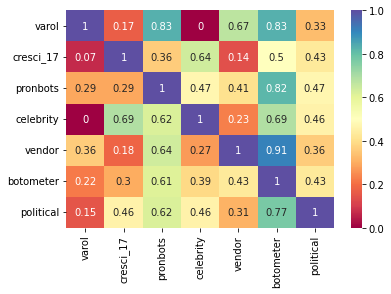

In [9]:
import seaborn as sns

graph = sns.heatmap(data=conditional_table, annot=True, cmap="Spectral")

In [12]:
#get the ranks of the models in original table 4 for comparison
lookup_names = ["M1101011", "M1101010", "M1101110", "M1111111"]
table4 = ranked_results.loc[ranked_results['name'].isin(lookup_names)]

#get the names used in the paper
model_name_conversion = {"M1101011": "M196",
                         "M1101010": "M125",
                         "M1101110": "M191",
                         "M1111111": "M246_revised"}
table4['name'] = table4.apply(lambda row: model_name_conversion[row['name']], axis=1)

#reorder to have models in same order as paper
table4 = table4.set_index("name").transpose()[["M196", "M125", "M191", "M246_revised"]]

table4_file = os.path.join(results_path, "table4.csv")
table4.to_csv(table4_file)
table4

/tmp/ipykernel_2141/3850043466.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table4['name'] = table4.apply(lambda row: model_name_conversion[row['name']], axis=1)


name,M196,M125,M191,M246_revised
botwiki-verified,0.976,0.977,0.976,0.981
midterm-18,0.954,0.956,0.963,0.966
gilani-17,0.688,0.680,0.682,0.675
cresci-rtbust,0.618,0.647,0.646,0.635
5-fold_cross-validation,0.991,0.990,0.988,0.994
spearman_r,0.486,0.478,0.498,0.546
rank,90.000,91.000,84.000,61.000


In [13]:
# Seven training datasets
dataset_path = "data_csv/final"

varol = pd.read_csv(dataset_path + '/varol-17.csv')
cresci_17 = pd.read_csv(dataset_path + '/cresci-17.csv')
pronbots = pd.read_csv(dataset_path + '/pronbots-2019.csv')
celebrity = pd.read_csv(dataset_path + '/celebrity-2019.csv')
vendor = pd.read_csv(dataset_path + '/vendor-purchased-2019.csv')
botometer = pd.read_csv(dataset_path + '/botometer-feedback-2019.csv')
political = pd.read_csv(dataset_path + '/political-bots-2019.csv')

# Testing datasets
botwiki = pd.read_csv(dataset_path + '/botwiki-verified.csv')
midterm = pd.read_csv(dataset_path + '/midterm-2018.csv')
gilani = pd.read_csv(dataset_path + '/gilani-2017.csv')
c_rtbust = pd.read_csv(dataset_path + '/cresci-rtbust-2019.csv')

In [20]:
#get the breakdown of how many observations are in each class for all datasets

datasets = [varol, cresci_17, pronbots, celebrity, vendor, botometer, political, botwiki, midterm, gilani, c_rtbust]
dataset_names = ["varol-icwsm", "cresci-17", "pronbots", "celebrity", "vendor-purchased", "botometer-feedback", "political-bots", "botwiki-verified", "midterm-18", "gilani-17", "cresci-rtbust"]

dataset_analysis = []
for i, dataset in enumerate(datasets):
  name = dataset_names[i]
  bots = sum(dataset['is_bot'] == 1)
  humans = sum(dataset['is_bot'] == 0)
  dataset_analysis.append([name, bots, humans])

dataset_analysis

[['varol-icwsm', 665, 1441],
 ['cresci-17', 6543, 3474],
 ['pronbots', 17882, 0],
 ['celebrity', 0, 5918],
 ['vendor-purchased', 1087, 0],
 ['botometer-feedback', 138, 380],
 ['political-bots', 62, 0],
 ['botwiki-verified', 698, 1987],
 ['midterm-18', 42446, 8092],
 ['gilani-17', 1090, 1394],
 ['cresci-rtbust', 353, 340]]

In [14]:
import joblib
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict, StratifiedShuffleSplit, ShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [15]:
all_test_data = pd.concat([botwiki, gilani, midterm, c_rtbust], ignore_index=True)
m196_cv_data = pd.concat([varol, cresci_17, celebrity, botometer, political], ignore_index=True)

all_test_data_X = all_test_data.drop("is_bot", axis=1)
all_test_data_Y = all_test_data["is_bot"]

m196_cv_data_X = m196_cv_data.drop("is_bot", axis=1)
m196_cv_data_Y = m196_cv_data["is_bot"]

In [16]:
#5 fold cross validation

clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=0)

ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
splits = ss.split(X=m196_cv_data_X, y=m196_cv_data_Y)

cv_predicted = pd.DataFrame(columns=["bot_prob"])
cv_Y = np.array([])

for split in splits:
  train, test = split
  
  train_X = m196_cv_data_X.iloc[train]
  train_Y = m196_cv_data_Y.iloc[train]
  test_X = m196_cv_data_X.iloc[test]
  test_Y = m196_cv_data_Y.iloc[test]
  clf.fit(train_X, train_Y)


  cv_bot_scores =  pd.DataFrame(clf.predict_proba(test_X), columns = ["human_prob", "bot_prob"])
  predicted = cv_bot_scores.drop("human_prob", axis=1)

  #the predicted values are dataframes, the cv_Y values are numpy arrays
  cv_predicted = cv_predicted.append(predicted, ignore_index=True)
  cv_Y = np.concatenate((cv_Y, test_Y))

print(cv_predicted)
print(cv_Y)

/tmp/ipykernel_2141/1885325035.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_predicted = cv_predicted.append(predicted, ignore_index=True)
/tmp/ipykernel_2141/1885325035.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_predicted = cv_predicted.append(predicted, ignore_index=True)
/tmp/ipykernel_2141/1885325035.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_predicted = cv_predicted.append(predicted, ignore_index=True)
/tmp/ipykernel_2141/1885325035.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_predicted = cv_predicted.append(predicted, ignore_index=True)


       bot_prob
0          0.02
1          0.06
2          0.04
3          0.01
4          0.03
...         ...
18620      0.00
18621      1.00
18622      0.00
18623      0.01
18624      0.44

[18625 rows x 1 columns]
[0. 0. 0. ... 0. 0. 0.]


/tmp/ipykernel_2141/1885325035.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_predicted = cv_predicted.append(predicted, ignore_index=True)


In [ ]:
m196 = joblib.load(os.path.join(GOOGLE_DRIVE_PATH, "models/base_shuffle_CV/1101011.joblib"))

top_model_stripped = top_model.strip("M")
best_model = joblib.load(os.path.join(GOOGLE_DRIVE_PATH, f"models/base_shuffle_CV/{top_model_stripped}.joblib"))


test_data_bot_scores =  pd.DataFrame(m196.predict_proba(all_test_data_X), columns = ["human_prob", "bot_prob"])
test_data_predicted = test_data_bot_scores.drop("human_prob", axis=1)

#this is used for the bot scores distribution plot
predicted = pd.DataFrame()
predicted["cv_bot_scores"] = cv_predicted
predicted["test_data_scores"] = test_data_predicted

In [ ]:
thresholds = [x / 100 for x in range(0, 100 + 2, 2)] #0, 0.02, 0.04,... 1

threshold_f1 = pd.DataFrame(columns=["threshold", "test_data_f1", "cv_data_f1"])

for threshold in thresholds:
  test_data_classification = test_data_predicted.apply(lambda row: int(row["bot_prob"] >= threshold), axis=1)
  test_data_f1 = f1_score(all_test_data_Y, test_data_classification)

  cv_data_classification = cv_predicted.apply(lambda row: int(row["bot_prob"] >= threshold), axis=1)
  cv_data_f1 = f1_score(cv_Y, cv_data_classification)

  observation = {"threshold": threshold, "test_data_f1": test_data_f1, "cv_data_f1": cv_data_f1}
  
  threshold_f1 = threshold_f1.append(observation, ignore_index = True)

  print("Finished" , threshold)

#set index to help with automatic plotting of the index as x axis later
threshold_f1 = threshold_f1.set_index("threshold")

Finished 0.0
Finished 0.02
Finished 0.04
Finished 0.06
Finished 0.08
Finished 0.1
Finished 0.12
Finished 0.14
Finished 0.16
Finished 0.18
Finished 0.2
Finished 0.22
Finished 0.24
Finished 0.26
Finished 0.28
Finished 0.3
Finished 0.32
Finished 0.34
Finished 0.36
Finished 0.38
Finished 0.4
Finished 0.42
Finished 0.44
Finished 0.46
Finished 0.48
Finished 0.5
Finished 0.52
Finished 0.54
Finished 0.56
Finished 0.58
Finished 0.6
Finished 0.62
Finished 0.64
Finished 0.66
Finished 0.68
Finished 0.7
Finished 0.72
Finished 0.74
Finished 0.76
Finished 0.78
Finished 0.8
Finished 0.82
Finished 0.84
Finished 0.86
Finished 0.88
Finished 0.9
Finished 0.92
Finished 0.94
Finished 0.96
Finished 0.98
Finished 1.0


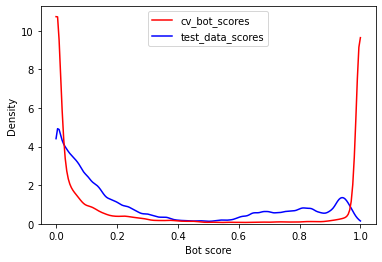

In [ ]:
graph = sns.kdeplot(data=predicted, common_norm=False, clip=(0,1), bw_adjust=0.2, palette=['r', 'b'])
graph.set(xlabel="Bot score")

fig = graph.get_figure()
fig.savefig(os.path.join(results_path, "fig4a.png"))

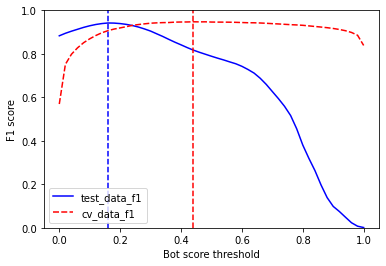

In [ ]:

graph = sns.lineplot(data=threshold_f1, palette=['b', 'r'])
graph.set(xlabel="Bot score threshold", ylabel="F1 score", ylim=(0,1))

#get index of observation with highest f1_score, then retrieve its threshold
maxes = threshold_f1.idxmax(axis=0)
max_test_f1_threshold = maxes["test_data_f1"]
max_cv_f1_threshold = maxes["cv_data_f1"]


graph.axvline(max_test_f1_threshold, linestyle="--", color="blue")
graph.axvline(max_cv_f1_threshold, linestyle="--", color="red")

fig = graph.get_figure()
fig.savefig(os.path.join(results_path, "figure4b.png"))

In [27]:
#load results
stds = pd.read_csv(os.path.join(results_path, "std.csv"))
#make all the strings 7 digits long by adding zeros in front
stds["name"] = stds.apply(lambda row: "M" + str(int(row["name"])).zfill(7), axis=1)

stds["std_rank"] = stds.mean(numeric_only=True, axis=1).rank()

stds.sort_values("std_rank")

stds_ranks = stds.merge(ranked_results, on="name")


train_datasets_size = [len(df) for df in datasets[:7]]

def get_train_size(model_name):
  name = model_name.strip("M")
  size = 0
  
  for i, c in enumerate(name):
    if c == "1":
      size += train_datasets_size[i]

  return size

stds_ranks["train_size"] = stds.apply(lambda row: get_train_size(row["name"]), axis=1)

#correlation between avg std rank (lower std lower/better rank) to model performance rank

stds_ranks[["std_rank", "rank", "train_size"]].corr(method="spearman")


,std_rank,rank,train_size
std_rank,1.000000,0.333072,-0.299544
rank,0.333072,1.000000,-0.137851
train_size,-0.299544,-0.137851,1.000000
